In [1]:
import os, random, copy
import seaborn as sns
import pandas as pd
import numpy as np
from os.path import join as opj
import matplotlib.pyplot as plt
from utils import label_point, ci_95
%matplotlib inline
%autosave 5

Autosaving every 5 seconds


In [2]:
# from IPython.display import display, Javascript

# # JavaScript to get the notebook's name and pass it to a Python variable
# js_code = """
# const notebookPath = IPython.notebook.notebook_path;
# const notebookName = IPython.notebook.notebook_name;
# IPython.notebook.kernel.execute("notebook_path = '" + notebookPath + "'");
# IPython.notebook.kernel.execute("notebook_name = '" + notebookName + "'");
# """

# display(Javascript(js_code))
# OUT_DIR = opj(CUR_DIR, 'output', 'out_figure'.format(notebook_name.split('.ipynb')[0]))

# Note <a name="Note"></a>

<p><b>"wovenab" : </b> Woven-ablation </p>
<p><b>"wovenab2" : </b> Ablation+ </p>
<p><b>"dnn2" : </b> Best-corr. DNN</p>


In [3]:
COND = 'stiff'

CUR_DIR = os.getcwd()

DATA_DIR = opj(CUR_DIR, 'data')
BOOTSTRAP_DIR = opj(DATA_DIR, 'parsed_questions_bootstrap')
COND_F = pd.read_csv(opj(DATA_DIR, f'parsed_questions_{COND}.csv'))

OUT_DIR = opj(CUR_DIR, 'output', 'out_figures')
os.makedirs(OUT_DIR, exist_ok=True)

MODELS = ['human', 'woven', 'dnn', 'wovenab', 'wovenab2', 'dnn2']
MODELS_WITHOUT_HUMAN = ['woven', 'dnn', 'wovenab', 'wovenab2', 'dnn2']
BASELINE_MODELS = ['dnn', 'wovenab', 'wovenab2', 'dnn2']

## 1. Tile plots showing the fine-grained accuracy levels of humans and models

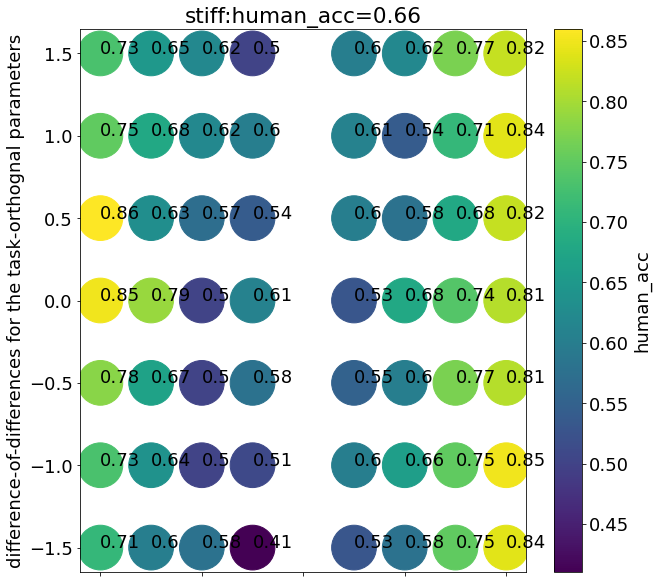

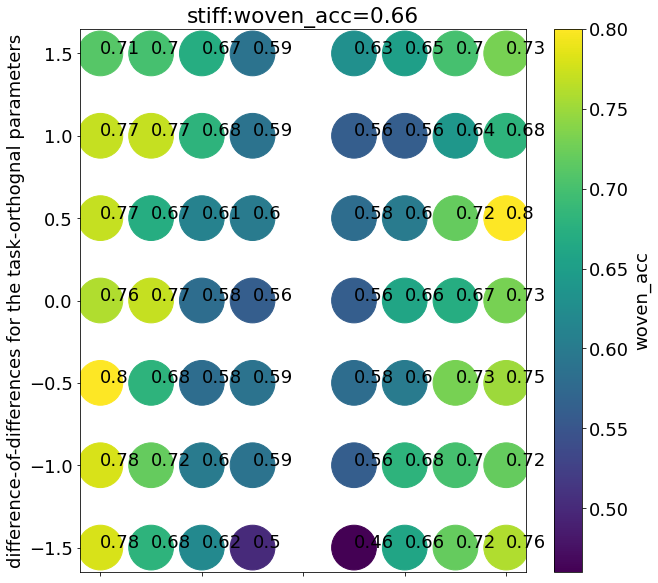

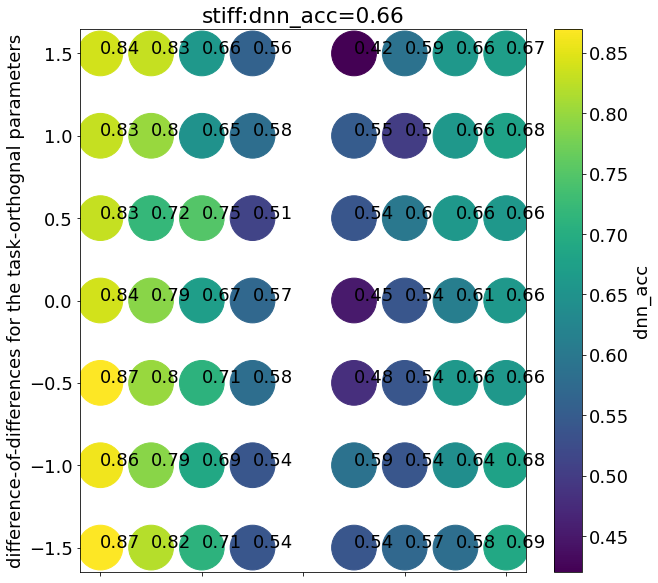

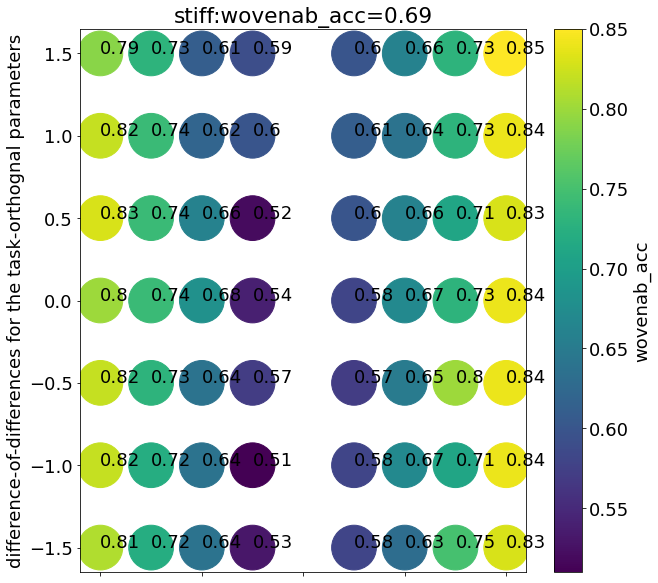

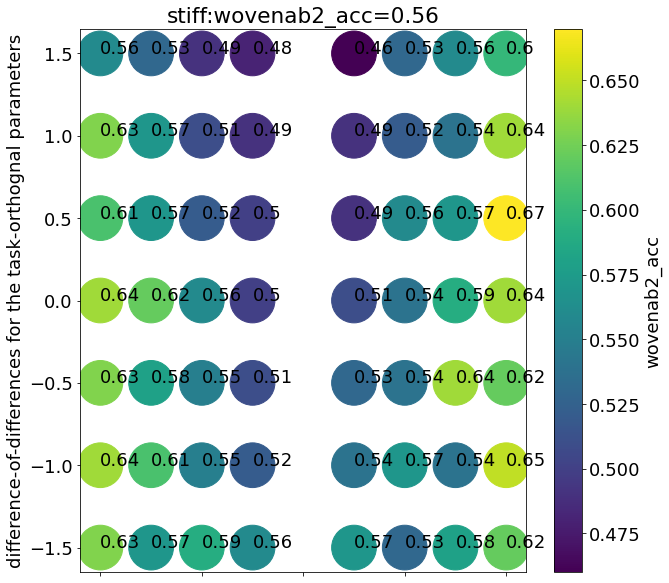

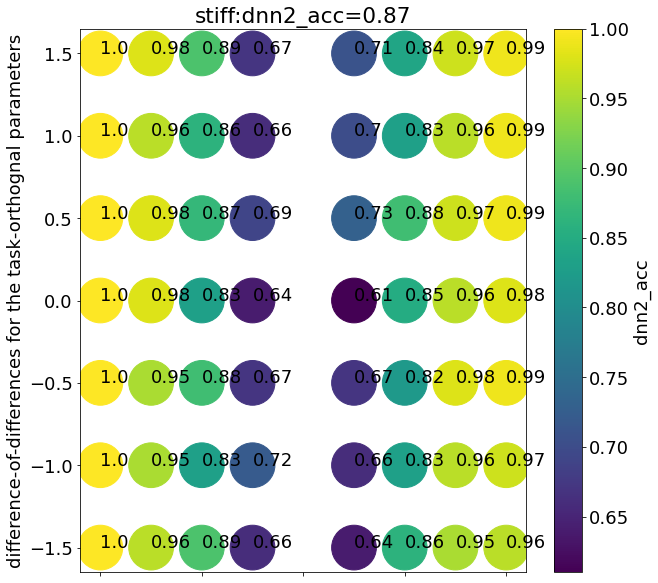

In [4]:
plot_data = COND_F.groupby(['reldiff', 'ireldiff']).agg({
    'woven_acc': 'mean',
    'human_acc': 'mean',
    'dnn_acc': 'mean',
    'wovenab_acc': 'mean',
    'wovenab2_acc': 'mean',
    'dnn2_acc': 'mean',
}).reset_index()
plot_data = plot_data.round(2)

plt.rcParams.update({'font.size': 18})

for _model in MODELS:
    _model = _model + '_acc'
    ax = plot_data.plot.scatter(x='reldiff', y='ireldiff', c=_model, colormap='viridis', s=2000, figsize=(10, 10))
    label_point(plot_data['reldiff'], plot_data['ireldiff'], plot_data[_model], ax)
    plt.ylabel("difference-of-differences for the task-orthognal parameters")
    plt.xlabel("differences for the task-relevant parameter")
    fname = f"{COND}:{_model}={round(np.mean(plot_data[_model]),2)}"
    plt.title(fname)
    #plt.savefig(opj(OUT_DIR, fname+'.svg'), format="svg", dpi=300)
    plt.show()


## 2. Correlation of accuracy between human and models

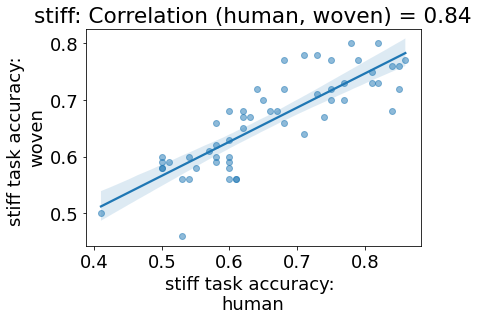

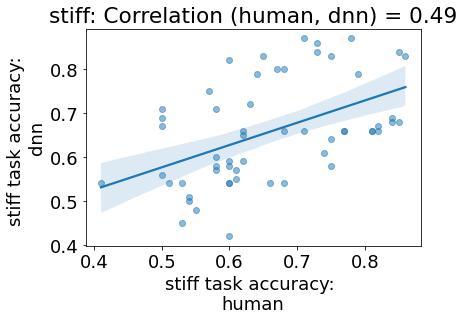

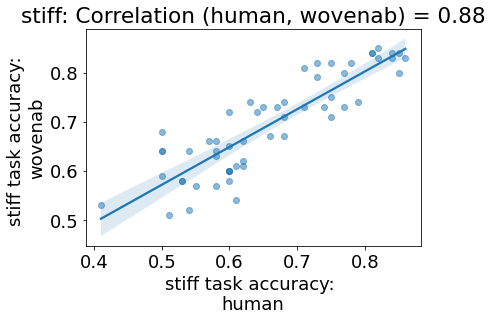

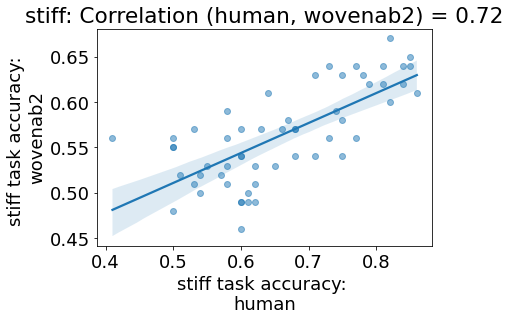

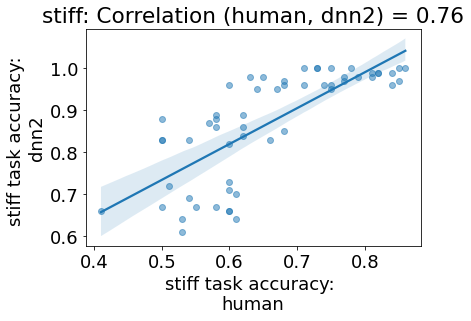

In [5]:
for _model in MODELS_WITHOUT_HUMAN:
    plt.figure()
    cor = np.corrcoef(plot_data[f'{_model}_acc'], plot_data['human_acc'])[0][1]
    
    sns.regplot(x=plot_data['human_acc'], y=plot_data[f'{_model}_acc'], ci=95, scatter_kws={'alpha':0.5})
    
    fname = f'{COND}: Correlation (human, {_model}) = {round(cor, 2)}'
    plt.title(fname)
    plt.xlabel(f"{COND} task accuracy: \nhuman")
    plt.ylabel(f"{COND} task accuracy: \n{_model}")
    #plt.savefig(opj(OUT_DIR, fname+'.svg'), format="svg", dpi=300)
    plt.show()


## 3. Average accuracy levels of all models

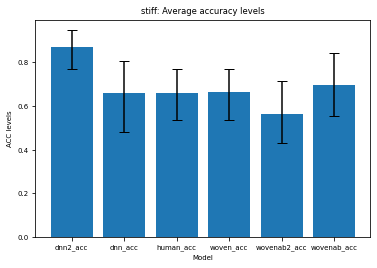

In [6]:
## Get 95% CI
def ci_95(x):
    return np.percentile(x['acc'], [2.5, 97.5])

all_acc = COND_F.melt(id_vars=['iter_sub'], value_vars=[f'{i}_acc' for i in MODELS], 
                      var_name='model', value_name='acc')

# 95% ci
all_acc_ci = all_acc.groupby(['iter_sub', 'model']).mean().reset_index()
all_acc_ci = all_acc_ci.groupby(['model']).apply(ci_95).reset_index()
all_acc_ci[['CI_lower', 'CI_upper']] = pd.DataFrame(all_acc_ci[0].tolist(), index=all_acc_ci.index)
all_acc_ci = all_acc_ci.drop(columns=[0])
all_acc_ci = all_acc_ci.sort_values(by=['model'])

# mean
all_acc_mean = all_acc.groupby(['model']).mean().reset_index()
all_acc_mean = all_acc_mean.sort_values(by=['model'])

## Merge acc with CI
all_acc_plot = all_acc_mean.merge(all_acc_ci, on=['model'])

### Plot
errors = all_acc_plot['acc'] - all_acc_plot['CI_lower'], all_acc_plot['CI_upper'] - all_acc_plot['acc']
plt.rcParams.update({'font.size': 7})
fig, ax = plt.subplots()
ax.bar(all_acc_plot['model'], all_acc_plot['acc'], yerr=errors, capsize=5)
ax.set_xlabel('Model')
ax.set_ylabel('ACC levels')
ax.set_title(f'{COND}: Average accuracy levels')
#plt.savefig(opj(OUT_DIR, f'mean_acc_{COND}.svg'), format="svg", dpi=300)
plt.show()

## 4. Model comparison by excluding each scene: line plot showing accuracy

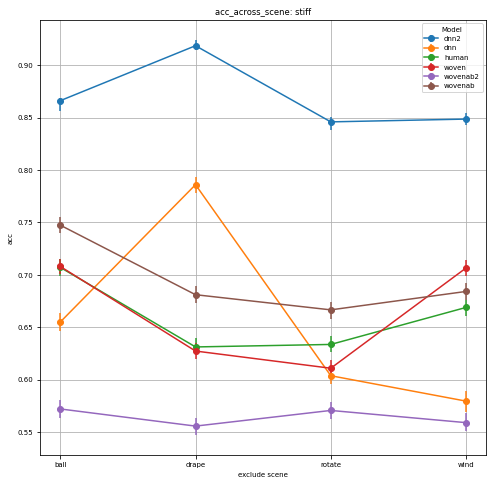

In [7]:
## Get 95% CI
def ci_95(x):
    return np.percentile(x['acc'], [2.5, 97.5])

each_scene_acc_conf_f = pd.read_csv(opj(BOOTSTRAP_DIR, f'acc_each_scene_{COND}.csv'))
each_scene_acc_conf_f = each_scene_acc_conf_f.melt(id_vars=['exclude_scene', 'iter'], 
                                                   value_vars=[f'{i}_acc' for i in MODELS], 
                                                   var_name='model', value_name='acc')

ci_results = each_scene_acc_conf_f.groupby(['exclude_scene', 'model']).apply(ci_95).reset_index()
ci_results[['CI_lower', 'CI_upper']] = pd.DataFrame(ci_results[0].tolist(), index=ci_results.index)
ci_results = ci_results.drop(columns=[0])
ci_results = ci_results.sort_values(by=['exclude_scene', 'model'])

## Get mean acc
each_scene_acc_data = COND_F.groupby(['exclude_scene']).agg({
    'woven_acc': 'mean',
    'human_acc': 'mean',
    'dnn_acc': 'mean',
    'wovenab_acc': 'mean',
    'wovenab2_acc': 'mean',
    'dnn2_acc': 'mean'
}).reset_index()

each_scene_acc_data = each_scene_acc_data.melt(id_vars=['exclude_scene'], 
                                               value_vars=[f'{i}_acc' for i in MODELS], 
                                               var_name='model', value_name='acc')
each_scene_acc_data = each_scene_acc_data.sort_values(by=['exclude_scene', 'model'])

## Merge acc with CI
each_scene_acc_data_plot = each_scene_acc_data.merge(ci_results, on=['exclude_scene', 'model'])


## Plot
plt.figure(figsize=(8, 8))
each_scene_acc_models = each_scene_acc_data_plot['model'].unique()
colors = sns.color_palette(n_colors=len(each_scene_acc_models))

for model, color in zip(each_scene_acc_models, colors):
    subset = each_scene_acc_data_plot[each_scene_acc_data_plot['model'] == model]
    subset = subset.sort_values(by='exclude_scene')
    plt.errorbar(subset['exclude_scene'], subset['acc'], 
                 yerr=[subset['acc']-subset['CI_lower'], subset['CI_upper']-subset['acc']], 
                 fmt='-o', label=model, color=color)

plt.xlabel('exclude scene')
plt.ylabel('acc')
fname = f'acc_across_scene: {COND}'
plt.title(fname)
plt.legend([i.split('_')[0] for i in each_scene_acc_models], title='Model')
plt.grid(True)
#plt.savefig(opj(OUT_DIR, fname+'.svg'), format="svg", dpi=300)
plt.show()

## 5. Model comparisons: bar plot showing correlation for all models

Task: stiff



<Figure size 720x576 with 0 Axes>

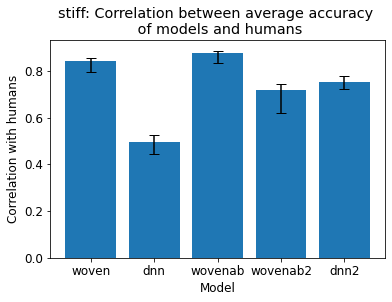

In [8]:
def ci_95(x):
    return np.percentile(x, [2.5, 97.5])


ci_f = pd.read_csv(opj(BOOTSTRAP_DIR, f'cor_{COND}.csv'))
plot_pd = []
print(f"Task: {COND}\n")
for _model in MODELS_WITHOUT_HUMAN:
    cur_ci = ci_95(ci_f[f'cor_{_model}'])
    plot_pd += [list(cur_ci)]

df = pd.DataFrame(plot_pd, columns=['lower', 'higher'])

# Get mean
acc_mean_data = COND_F.groupby(['reldiff', 'ireldiff']).agg({
    'woven_acc': 'mean',
    'human_acc': 'mean',
    'dnn_acc': 'mean',
    'wovenab_acc': 'mean',
    'wovenab2_acc': 'mean',
    'dnn2_acc': 'mean'
}).reset_index()

df['mean'] = [np.corrcoef(acc_mean_data[f'{i}_acc'], acc_mean_data['human_acc'])[0][1] for i in MODELS_WITHOUT_HUMAN]
df['name'] = MODELS_WITHOUT_HUMAN

### Plot
errors = df['mean'] - df['lower'], df['higher'] - df['mean']
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10, 8))
fig, ax = plt.subplots()
ax.bar(df['name'], df['mean'], yerr=errors, capsize=5)
ax.set_xlabel('Model')
ax.set_ylabel('Correlation with humans')
ax.set_title(f'{COND}: Correlation between average accuracy \n of models and humans')
#plt.savefig(opj(OUT_DIR, f'mean_correlation_with_human_{COND}.svg'), format="svg", dpi=300)
plt.show()

## 6. Model comparison by excluding each scene: bar plot showing correlation

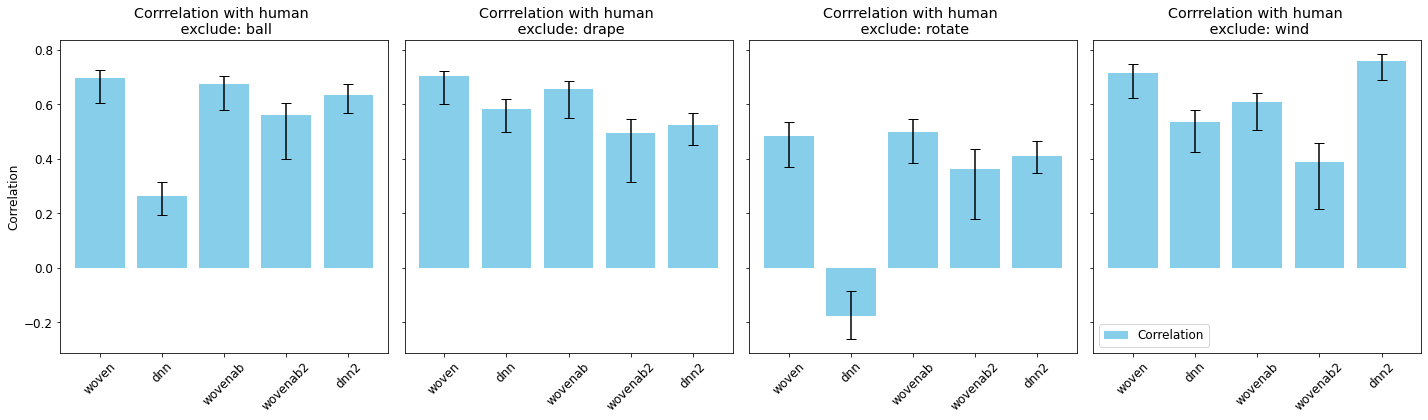

In [9]:
# Get mean cor
def get_cor(x, order):
    return [np.corrcoef(x[f'{i}_acc'], x['human_acc'])[0][1] for i in order]

each_scene_cor_data = COND_F.groupby(['reldiff', 'ireldiff', 'exclude_scene']).agg({
        'woven_acc': 'mean',
        'human_acc': 'mean',
        'dnn_acc': 'mean',
        'wovenab_acc': 'mean',
        'wovenab2_acc': 'mean',
        'dnn2_acc': 'mean'
    }).reset_index()

each_scene_cor_data = each_scene_cor_data.groupby(['exclude_scene']).apply(lambda x: get_cor(x, MODELS_WITHOUT_HUMAN)).reset_index()
each_scene_cor_data[[f'cor_{i}' for i in MODELS_WITHOUT_HUMAN]] = pd.DataFrame(each_scene_cor_data[0].tolist(), 
                                                                               index=each_scene_cor_data.index)
each_scene_cor_data = each_scene_cor_data.drop(columns=[0])
each_scene_cor_data = each_scene_cor_data.melt(id_vars=['exclude_scene'], 
                                               value_vars=[f'cor_{i}' for i in MODELS_WITHOUT_HUMAN], 
                                               var_name='model', value_name='cor')

## Get 95% CI
def ci_95(x):
    return np.percentile(x['cor'], [2.5, 97.5])

each_scene_cor_conf_f = pd.read_csv(opj(BOOTSTRAP_DIR, f'cor_each_scene_{COND}.csv'))
each_scene_cor_conf_f = each_scene_cor_conf_f.melt(id_vars=['exclude_scene'], 
                                                   value_vars=[f'cor_{i}' for i in MODELS_WITHOUT_HUMAN], 
                                                   var_name='model', value_name='cor')

ci_results = each_scene_cor_conf_f.groupby(['exclude_scene', 'model']).apply(ci_95).reset_index()
ci_results[['CI_lower', 'CI_upper']] = pd.DataFrame(ci_results[0].tolist(), index=ci_results.index)
ci_results = ci_results.drop(columns=[0])
ci_results = ci_results.sort_values(by=['exclude_scene', 'model'])

## Merge cor with ci
each_scene_cor_data_plot = each_scene_cor_data.merge(ci_results, on=['exclude_scene', 'model'])

## Plot
scenes = each_scene_cor_data_plot['exclude_scene'].unique()
n_scenes = len(scenes)

fig, axs = plt.subplots(1, n_scenes, figsize=(5*n_scenes, 6), sharey=True)

if n_scenes == 1:
    axs = np.array([axs])

for ax, scene in zip(axs, scenes):
    subset = each_scene_cor_data_plot[each_scene_cor_data_plot['exclude_scene'] == scene]
    x = np.arange(len(subset))
    errors = [subset['cor'] - subset['CI_lower'], subset['CI_upper'] - subset['cor']]
    
    ax.bar(x, subset['cor'], yerr=errors, capsize=5, color='skyblue', label='Correlation')
    ax.set_xticks(x)
    ax.set_xticklabels([i.split('_')[-1] for i in subset['model']],  rotation=45)
    ax.set_title(f'Corrrelation with human \n exclude: {scene}')
    ax.set_ylabel('Correlation' if ax is axs[0] else "")
    
ax.legend()
plt.tight_layout()
#plt.savefig(opj(OUT_DIR, f'cor_across_scene_bar_{COND}.svg'), format="svg", dpi=300)
plt.show()

## 7. Correlation between human and model accuracy levels by scene configurations

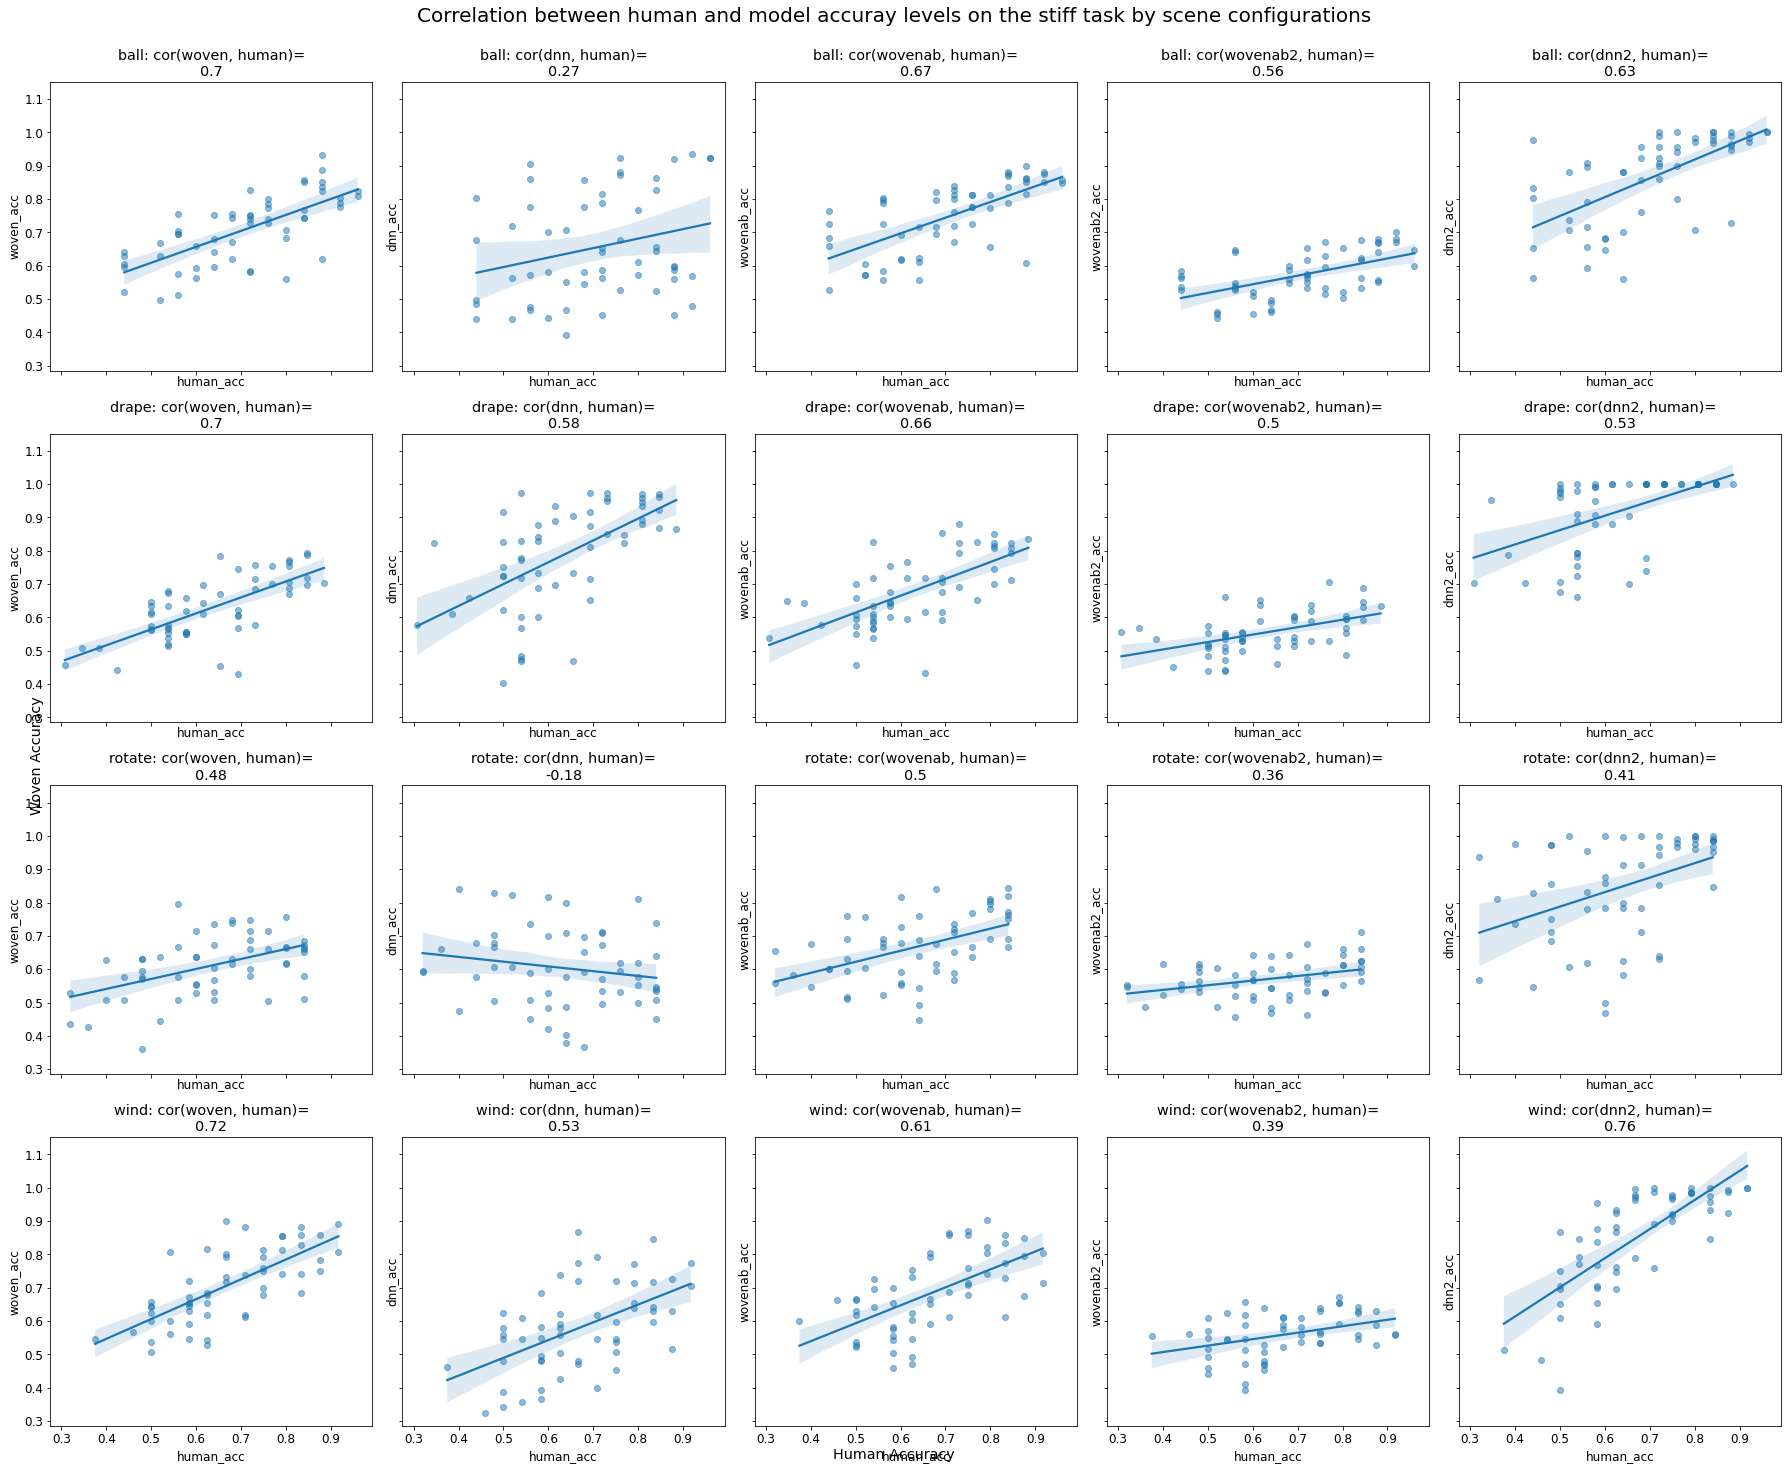

In [11]:
each_scene_cor_data = COND_F.groupby(['reldiff', 'ireldiff', 'exclude_scene']).agg({
        'woven_acc': 'mean',
        'human_acc': 'mean',
        'dnn_acc': 'mean',
        'wovenab_acc': 'mean',
        'wovenab2_acc': 'mean',
        'dnn2_acc': 'mean'
    }).reset_index()


scenes = each_scene_cor_data['exclude_scene'].unique()
n_scenes = len(scenes)

n_rows = len(scenes)
n_cols = len(MODELS_WITHOUT_HUMAN)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows), sharex=True, sharey=True)

# Ensure axs is properly indexed even if there's only one row or column
if n_rows == 1: axs = axs.reshape(1, -1)
if n_cols == 1: axs = axs.reshape(-1, 1)

for i, scene in enumerate(scenes):
    for j, model in enumerate(MODELS_WITHOUT_HUMAN):
        ax = axs[i, j] if n_rows > 1 else axs[j]
        subset = each_scene_cor_data[(each_scene_cor_data['exclude_scene'] == scene)]  
        cor = round(np.corrcoef(subset[f'{model}_acc'], subset['human_acc'])[0][1], 2)
        sns.regplot(x='human_acc', y=f'{model}_acc', data=subset, ci=95, scatter_kws={'alpha':0.5}, ax=ax)
        ax.set_title(f'{scene}: cor({model}, human)=\n{cor}')
        
plt.tight_layout()

fig.supxlabel('Human Accuracy')
fig.supylabel('Woven Accuracy')
plt.suptitle(f'Correlation between human and model accuray levels on the {COND} task by scene configurations', 
             fontsize=20, y=1.02)
#plt.savefig(opj(OUT_DIR, f'cor_across_scene_scatter_{COND}.svg'), format="svg", dpi=300)
plt.show()